In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_split,
create_eval_df,
apply_differencing)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_evaluation
)
%load_ext skip_kernel_extension

In [2]:
SKIP_SARIMAX =False

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Loading Data

In [4]:
base_df = pd.read_csv("preprocessed_data.csv")
base_df = set_timestamp_index(base_df,"Unnamed: 0")

In [5]:
base_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


In [6]:
diff_df = apply_differencing(base_df,[])
diff_df.index.tz_convert('utc')
diff_df.freq = '1H'

### Singlestep prediction


Creating test-train-split datasets


In [7]:
%%skip $SKIP_SARIMAX

train_start = "2015-01-01"
test_start = "2017-01-01"
test_end = "2017-01-02"
base_df.index.freq = "h"
modeltype = 'SARIMAX'
namespace = "SARIMAX"
feature = 'price actual'
exog_feature = 'total load actual'
feature_df = diff_df[[feature]]
exog_df = diff_df[[exog_feature]]

_,data_y_train = create_split(base_df,feature_df,train_start,test_start)
_,data_y_test = create_split(base_df,feature_df,test_start,test_end)
_,data_exog_train = create_split(base_df,exog_df,train_start,test_start)
_,data_exog_test = create_split(base_df,exog_df,test_start,test_end)

Scaling dataset with MinMaxScaler


In [8]:
%%skip $SKIP_SARIMAX

scaler_1 = pp.MinMaxScaler()
scaler_2 = pp.MinMaxScaler()
data_y_train[feature] = scaler_1.fit_transform(data_y_train)
data_y_test[feature] = scaler_1.transform(data_y_test)

data_exog_train[exog_feature] = scaler_2.fit_transform(data_exog_train)
data_exog_test[exog_feature] = scaler_2.transform(data_exog_test)

Hyperparameter setttings for SARIMAX

In [9]:
%%skip $SKIP_SARIMAX

horizon = 1
order = (3, 2, 8)
seasonal_order = (1, 1, 1, 24)
exog = data_exog_train

Preparing data for SARIMAX


In [10]:
%%skip $SKIP_SARIMAX

test_ts, history, predictions, history_temp, predictions_temp = prepare_data_sarimax(
    data_y_train = data_y_train,
    data_y_test = data_y_test,
    horizon = horizon,
    training_window=720,
    feature=feature,
    exog_feature=exog_feature,
    exog_y_train = data_exog_train,
    exog_y_test = data_exog_test,
)

In [11]:
test_ts

,price actual
2017-01-01 00:00:00+01:00,0.431484
2017-01-01 01:00:00+01:00,0.488428
2017-01-01 02:00:00+01:00,0.397502
2017-01-01 03:00:00+01:00,0.407421
2017-01-01 04:00:00+01:00,0.426525
2017-01-01 05:00:00+01:00,0.447649
2017-01-01 06:00:00+01:00,0.472998
2017-01-01 07:00:00+01:00,0.484203
2017-01-01 08:00:00+01:00,0.481631
2017-01-01 09:00:00+01:00,0.495040


Model Predictions


In [12]:
%%skip $SKIP_SARIMAX

for t in range(0, test_ts.shape[0], horizon):

    model = SARIMAX(
        endog=history, exog=history_temp, order=order, seasonal_order=seasonal_order
    )
    model_fit = model.fit()
    y_p = model_fit.forecast(
        steps=horizon, exog=predictions_temp.iloc[:horizon].to_frame()
    ).tolist()

    obs = list(test_ts.iloc[t])
    predictions.extend(y_p)

    history = history.append(
        pd.Series(
            y_p,
            index=pd.date_range(
                start=history.index[-1] + timedelta(hours=1), periods=horizon, freq="h"
            ),
        )
    )
    history = history[horizon:]

    history_temp = history_temp.append(predictions_temp.iloc[:horizon])
    history_temp.drop(index=history_temp.index[:horizon], inplace=True)
    predictions_temp.drop(index=predictions_temp.index[:horizon], inplace=True)

    print(test_ts.index[t])
    print(t + 1, ": predicted =", y_p, "true value =", obs)



C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2017-01-01 00:00:00+01:00
1 : predicted = [0.42593041146188415] true value = [0.4314842027920648]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 01:00:00+01:00
2 : predicted = [0.3815693945312444] true value = [0.4884276267450407]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 02:00:00+01:00
3 : predicted = [0.428393291480646] true value = [0.39750183688464374]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 03:00:00+01:00
4 : predicted = [0.43451548786272015] true value = [0.4074210139603234]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 04:00:00+01:00
5 : predicted = [0.45080195115691857] true value = [0.42652461425422505]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 05:00:00+01:00
6 : predicted = [0.49912499156129453] true value = [0.44764878765613525]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 06:00:00+01:00
7 : predicted = [0.5386438977528277] true value = [0.4729977957384277]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 07:00:00+01:00
8 : predicted = [0.5807616025403646] true value = [0.48420279206465855]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 08:00:00+01:00
9 : predicted = [0.5229696921091764] true value = [0.48163115356355624]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 09:00:00+01:00
10 : predicted = [0.4700864155131279] true value = [0.4950404114621603]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 10:00:00+01:00
11 : predicted = [0.5267253372062054] true value = [0.48236590742101415]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 11:00:00+01:00
12 : predicted = [0.4683435172719398] true value = [0.5275532696546658]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 12:00:00+01:00
13 : predicted = [0.47947067372062296] true value = [0.5123071271124174]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 13:00:00+01:00
14 : predicted = [0.49091981992946476] true value = [0.4656502571638502]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 14:00:00+01:00
15 : predicted = [0.48682194065317647] true value = [0.45132255694342416]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 15:00:00+01:00
16 : predicted = [0.453345561994278] true value = [0.4851212343864805]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 16:00:00+01:00
17 : predicted = [0.48359935547648275] true value = [0.49136664217487164]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 17:00:00+01:00
18 : predicted = [0.5617790493211534] true value = [0.5867009551800147]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 18:00:00+01:00
19 : predicted = [0.6233942188787942] true value = [0.6048861131520941]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 19:00:00+01:00
20 : predicted = [0.5014423124158879] true value = [0.49944893460690687]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 20:00:00+01:00
21 : predicted = [0.48347223610967216] true value = [0.5102865540044087]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 21:00:00+01:00
22 : predicted = [0.47371920887371927] true value = [0.4208302718589274]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 22:00:00+01:00
23 : predicted = [0.4407849716627933] true value = [0.4454445260837619]


C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Benjamin\anaconda3\envs\dde\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


2017-01-01 23:00:00+01:00
24 : predicted = [0.417014938508129] true value = [0.3679279941219694]


In [13]:
assert False

AssertionError: 

Create eval_df


In [16]:
# %%skip $SKIP_SARIMAX
# print(predictions)
# print(test_ts)
predictions
predictions = np.array(predictions).reshape((-1,1))
predictions = scaler_1.inverse_transform(predictions)
data_y_test = scaler_1.inverse_transform(data_y_test)
data_y_test = pd.Series(data_y_test[:,0],index=test_ts.index)
predictions = pd.Series(predictions[:,0],index=test_ts.index)
eval_df = create_eval_df(predictions,data_y_test)


# eval_df = pd.DataFrame(predictions)
# eval_df.columns = ['Prediction']
# eval_df=(eval_df.set_index(data_y_test.index)) 
# eval_df['Actual'] = data_y_test
# eval_df[['Prediction', 'Actual']] = 

R^2 score is  0.17


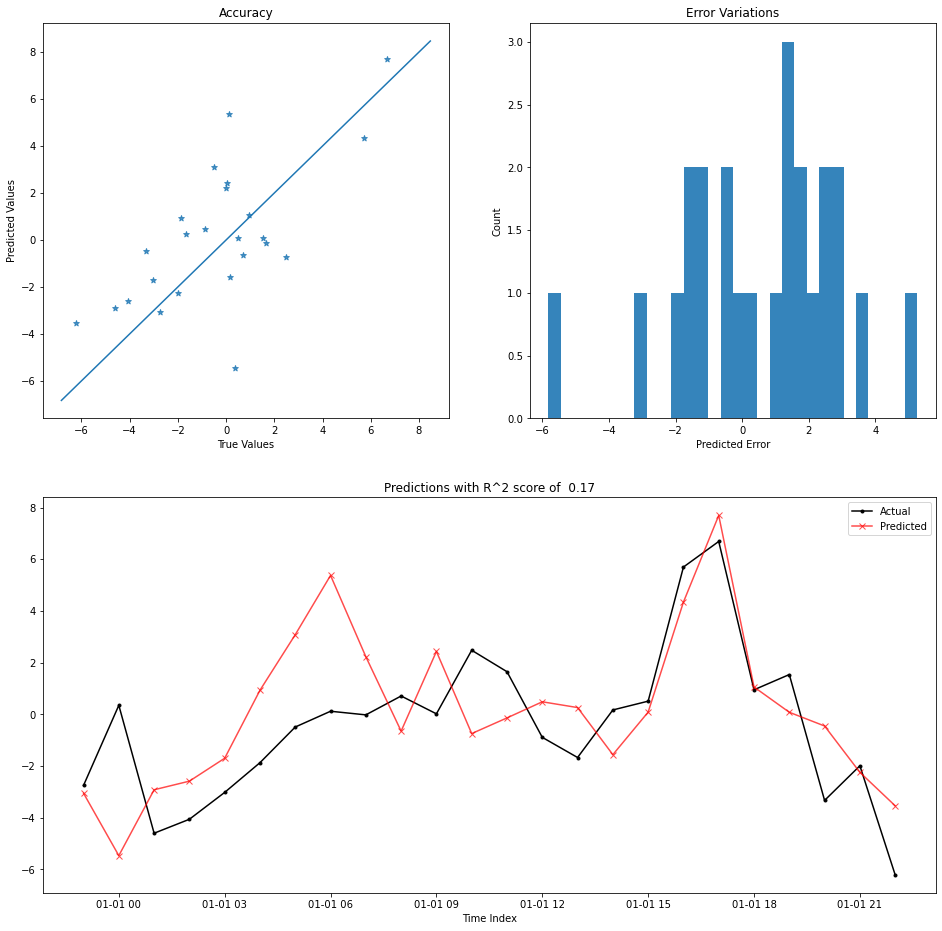

In [17]:
fig = plot_evaluation(eval_df)

### Multistep Prediction


Creating test-train-split datasets


In [ ]:
%%skip $SKIP_SARIMAX

train_start = "2015-01-01"
test_start = "2017-01-01"
test_end = "2017-01-02"
modeltype = 'SARIMAX'
namespace = "MS_SARIMAX"
feature = 'total load actual'
exog_feature = 'temp'
combined_df.index.freq = "h"

data_y_train,data_y_test,data_exog_train,data_exog_test = create_sarimax_test_train_split(combined_df,'total load actual','temp',train_start=train_start,test_start=test_start,test_end=test_end,)


Scaling dataset with MinMaxScaler


In [ ]:
%%skip $SKIP_SARIMAX

scaler_1 = pp.MinMaxScaler()
scaler_2 = pp.MinMaxScaler()
data_y_train[feature] = scaler_1.fit_transform(data_y_train)
data_y_test[feature] = scaler_1.transform(data_y_test)

data_exog_train[exog_feature] = scaler_2.fit_transform(data_exog_train)
data_exog_test[exog_feature] = scaler_2.transform(data_exog_test)

Hyperparameter setttings for SARIMAX


In [ ]:
%%skip $SKIP_SARIMAX

horizon = 6
order = (3, 2, 8)
seasonal_order = (1, 1, 1, 24)
exog = data_exog_train

Preparing data for SARIMAX


In [ ]:
%%skip $SKIP_SARIMAX

test_ts, history, predictions, history_temp, predictions_temp = prepare_data_sarimax(
    data_y_train = data_y_train,
    data_y_test = data_y_test,
    exog_y_train = data_exog_train,
    exog_y_test = data_exog_test,
    horizon = horizon,
    training_window=720,
    feature=feature,
    exog_feature=exog_feature,
)

Model Predictions


In [ ]:
%%skip $SKIP_SARIMAX

for t in range(0, test_ts.shape[0], horizon):

    model = SARIMAX(
        endog=history, exog=history_temp, order=order, seasonal_order=seasonal_order
    )
    
    model_fit = model.fit()
    
    y_p = model_fit.forecast(
        steps=horizon, exog=predictions_temp.iloc[:horizon].to_frame()
    ).tolist()

    obs = list(test_ts.iloc[t])
    predictions.extend(y_p)

    history = history.append(
        pd.Series(
            y_p,
            index=pd.date_range(
                start=history.index[-1] + timedelta(hours=1), periods=horizon, freq="h"
            ),
        )
    )
    history = history[horizon:]

    history_temp = history_temp.append(predictions_temp.iloc[:horizon])
    history_temp.drop(index=history_temp.index[:horizon], inplace=True)
    predictions_temp.drop(index=predictions_temp.index[:horizon], inplace=True)

    print(test_ts.index[t])
    print(t + 1, ": predicted =", y_p, "true value =", obs)



2017-01-01 00:00:00+01:00
1 : predicted = [0.26147010122792247, 0.17113258149196484, 0.0999416431429474, 0.06731052671354729, 0.06028758847078777, 0.0731103245773861] true value = [0.2854193780011668, 0.24018309922362346, 0.17358524435668443, 0.11551406902122696, 0.07122021271821566, 0.054346362698020845]
2017-01-01 06:00:00+01:00
7 : predicted = [0.12847368056615255, 0.23861239937089515, 0.340275689942, 0.4358124592999023, 0.49721369562723433, 0.502825659563985] true value = [0.058789211506529604, 0.07404748014181217, 0.06996364941883948, 0.09859534174034013, 0.17771395234034915, 0.24126015348023155]
2017-01-01 12:00:00+01:00
13 : predicted = [0.48507391059670363, 0.48323863778492165, 0.4459973822629454, 0.40095465030257976, 0.38637383417036975, 0.41706297869042164] true value = [0.2702957411479604, 0.29681820221693667, 0.2979401337342368, 0.24170892608715155, 0.22128977247228832, 0.24678005654534851]
2017-01-01 18:00:00+01:00
19 : predicted = [0.5243369921806, 0.5568144690680438, 0.5

Create eval_df


In [ ]:
%%skip $SKIP_SARIMAX

eval_df = pd.DataFrame(predictions)
eval_df.columns = ['Prediction']
eval_df=(eval_df.set_index(data_y_test.index)) 
eval_df['Actual'] = data_y_test[feature]
eval_df[['Prediction', 'Actual']] = scaler_1.inverse_transform(eval_df[['Prediction', 'Actual']])

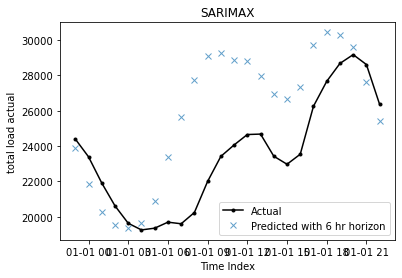

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_predictions(eval_df,horizon,modeltype,feature,f"./{modeltype}/predictions_{namespace}")

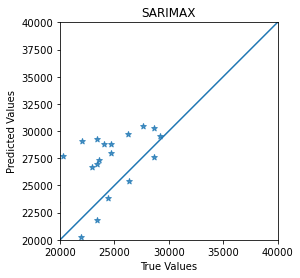

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}")

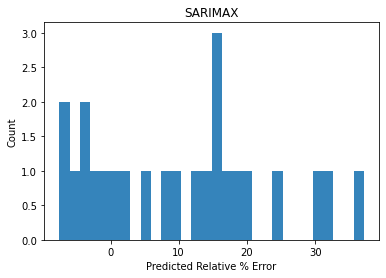

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}")

In [ ]:
%%skip $SKIP_SARIMAX

Score_sarimax = r2_score(eval_df['Actual'],eval_df['Prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

R^2 score is  -0.40


### Conclusion